## Data Loading

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt

DB_USER = "postgres"
DB_PASSWORD = "a"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Créer un moteur SQLAlchemy
engine = sqla.create_engine(connection_string)

try:
    with engine.connect() as connection:
        print("Connected to PostgreSQL successfully!")
except Exception as e:
    print(f"Error: {e}")

connection = engine.connect()

query = """
SELECT * FROM stations;
"""

stations = pd.read_sql(sqla.text(query), connection)

data_province = [
    (0,"Bruxelles", 4.367414882050033, 50.83642580516115),
    (1,"Antwerpen", 4.721043779498864, 51.231900712244745),
    (2,"Limburg", 5.4357209224443475, 50.98831159244354),
    (3,"Oost-Vlaanderen", 3.8188605810442007, 51.03629347952689),
    (4,"Vlaams Brabant", 4.59072072950776, 50.87303943005528),
    (5,"West-Vlaanderen", 3.0620446668608117, 51.01019740435232),
    (6,"Brabant Wallon", 4.589736973914637, 50.66605965845173),
    (7,"Hainaut", 3.9681364929631004, 50.46387637972707),
    (8,"Liège", 5.7372263688290746, 50.518876085615986),
    (9,"Luxembourg", 5.516735682549194, 49.95849015160492),
    (10,"Namur", 4.862346452029854, 50.252686235186815),
]

province = pd.DataFrame(data_province, columns=["province_id", "province_name", "province_long", "province_lat"])

def haversine(lon1, lat1, lon2, lat2):
    R = 6371  
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def find_nearest_province(station_row):
    distances = haversine(
        station_row['longitude'], station_row['latitude'],
        province['province_long'].values, province['province_lat'].values
    )
    nearest_idx = distances.argmin()
    return province.iloc[nearest_idx]

nearest_provinces = stations.apply(find_nearest_province, axis=1)

stations_with_province = pd.concat([stations.reset_index(drop=True), nearest_provinces.reset_index(drop=True)], axis=1)

road = [159,151,149,150,156,157,154,245,773,132,310,365,422,300,628,614,591,
 540,118,178,235,281,480,108,642,625,623,557,558,384,199,559,645,123,195,73,
 261,560,187,438,172,342,341,80,503,629,267,313,608,339,452,564,493,
 317,704,757,70]

filtered_stations = stations_with_province[stations_with_province['id'].isin(road)]
filtered_stations = filtered_stations.drop(columns=['province_long', 'province_lat','region', 'latitude', 'longitude', 'name', 'province_name'])
filtered_stations['id'] = pd.Categorical(filtered_stations['id'], categories=road, ordered=True)
filtered_stations = filtered_stations.sort_values('id').reset_index(drop=True)

query = """
SELECT 
    td.id,
    td.departure_date,
    td.train_number,
    td.relation,
    td.train_service,
    td.ptcar_number,
    td.line_number_departure,
    td.real_time_arrival,
    td.real_time_departure,
    td.planned_time_arrival,
    td.planned_time_departure,
    td.delay_arrival,
    td.delay_departure,
    ptcar.id AS ptcar_id,     
    ptcar.name AS name_travel,    
    td.line_number_arrival,
    dep.name AS departure_station_name,
    arr.name AS arrival_station_name,
    ptcar.longitude AS ptcar_longitude,  
    ptcar.latitude AS ptcar_latitude  
FROM train_data td
JOIN STATIONS ptcar ON td.ptcar_name = ptcar.id
JOIN STATIONS dep ON td.station_departure = dep.id
JOIN STATIONS arr ON td.station_arrival = arr.id
WHERE td.station_arrival = '487'  
  AND td.station_departure = '159'  
ORDER BY td.id;
"""

line = pd.read_sql(sqla.text(query), connection)
line =line.drop(columns=['train_service', 'relation'])
print("Road:", len(road))

tempo = []
clean = []
road_index = 0

for i, row in line.iterrows():
    ptcar_id = row['ptcar_id']
    if ptcar_id == road[road_index]:
        tempo.append(row)
        road_index += 1
        if len(tempo) == len(road):
            clean.extend(tempo)
            tempo = []
            road_index = 0
    else:
        tempo = []
        road_index = 0

clean_df = pd.DataFrame(clean)

query = """
    SELECT * FROM TYPE_DAY;
"""


type_day = pd.read_sql(sqla.text(query), connection)
clean_df= clean_df.drop(columns=['departure_station_name','arrival_station_name','id', 'name_travel', 'ptcar_number','ptcar_id'])
merged_df = pd.merge(clean_df, type_day, left_on='departure_date', right_on='date', how='left')
merged_df.loc[merged_df.index[::57], "delay_arrival"] = 0

merged_df.loc[merged_df.index[::57], "real_time_arrival"] = merged_df.loc[merged_df.index[::57], "real_time_departure"]
merged_df.loc[merged_df.index[::57], "planned_time_arrival"] = merged_df.loc[merged_df.index[::57], "planned_time_departure"]
merged_df.loc[merged_df.index[::57], "line_number_arrival"] = merged_df.loc[merged_df.index[::57], "line_number_departure"]


merged_df.loc[merged_df.index[56::57], "line_number_departure"] = 162
merged_df.loc[merged_df.index[56::57], "line_number_arrival"] = 162

index = merged_df.index[56::57]
mask = merged_df.loc[index, "real_time_departure"] == None
merged_df.loc[index, "real_time_departure"] = merged_df.loc[index, "real_time_arrival"]

mask = merged_df.loc[index, "planned_time_departure"] == None
merged_df.loc[index, "planned_time_departure"] = merged_df.loc[index, "planned_time_arrival"]

mask = merged_df.loc[index, "delay_departure"] == None
merged_df.loc[index, "delay_departure"] = merged_df.loc[index, "delay_arrival"]

station_ids = filtered_stations['province_id'].values
total_rows = 1558950
repeated_ids = np.tile(station_ids, total_rows // len(station_ids) + 1)[:total_rows]

repeated_ids_df = pd.DataFrame({'repeated_station_id': repeated_ids})
merged_df = pd.concat([merged_df, repeated_ids_df], axis=1)
query = """
SELECT 
    w.date,
    EXTRACT(HOUR FROM w.hour) AS hour_of_day,
    w.temperature AS temperature,
    w.dewpoint AS dewpoint,
    w.relative_humidity AS relative_humidity,
    w.precipitation AS precipitation,
    w.snowfall AS snowfall,
    w.wind_direction AS wind_direction,
    w.wind_speed AS wind_speed,
    w.pressure AS pressure,
    w.province AS province_id
FROM WEATHER w
GROUP BY 
    w.date,
    EXTRACT(HOUR FROM w.hour),
    w.temperature,
    w.dewpoint,
    w.relative_humidity,
    w.precipitation,
    w.snowfall,
    w.wind_direction,
    w.wind_speed,
    w.pressure,
    w.province
ORDER BY w.date, hour_of_day;

"""

weather = pd.read_sql(sqla.text(query), connection)

merged_df['time'] = pd.to_datetime(merged_df['planned_time_arrival'], format='%H:%M:%S')
merged_df['hour'] = merged_df['time'].dt.hour

final_df = pd.merge(merged_df, weather, left_on=['departure_date', 'hour','repeated_station_id'], right_on=['date', 'hour_of_day','province_id'], how='left')
final_df = final_df.drop(columns=['date_x', 'date_y', 'hour_of_day','time','hour','repeated_station_id'])
print("Middle of processing")
def parse_time_to_seconds(val):
    if pd.isna(val):
        return 0
    try:
        if isinstance(val, (int, float)):
            return int(val)
        if str(val).isdigit():
            return int(val)
        t = pd.to_datetime(val, format='%H:%M:%S', errors='coerce')
        if pd.isna(t):
            return 0
        return t.hour * 3600 + t.minute * 60 + t.second
    except Exception:
        return 0


final_df['departure_date'] = pd.to_datetime(final_df['departure_date'], format='%Y-%m-%d')

final_df['departure_year'] = final_df['departure_date'].dt.year
final_df['departure_month'] = final_df['departure_date'].dt.month
final_df['departure_day'] = final_df['departure_date'].dt.day
final_df['departure_weekday'] = final_df['departure_date'].dt.weekday

final_df['real_time_arrival'] = final_df['real_time_arrival'].apply(parse_time_to_seconds)
final_df['planned_time_arrival'] = final_df['planned_time_arrival'].apply(parse_time_to_seconds)
final_df['planned_time_departure'] = final_df['planned_time_departure'].apply(parse_time_to_seconds)
final_df['real_time_departure'] = final_df['real_time_departure'].apply(parse_time_to_seconds)

final_df = final_df.drop(columns=['departure_date', 'line_number_departure', 'line_number_arrival' ,'train_number'])
final_df['delay_arrival'] = final_df['delay_arrival'].apply(parse_time_to_seconds)

trajet_valid = []

for i in range(0, len(final_df), 57):
    trajet = final_df.iloc[i:i+57]
    if trajet.shape[0] < 57:
        print("Not enough data for this trajet, skipping")
        continue

    if trajet.isnull().values.any():
        continue

    if trajet['delay_arrival'].abs().max() > 36000:
        print("Delay arrival exceeds 10000 seconds, skipping")
        continue

    trajet_valid.append(trajet)

trajet_valid_df = pd.concat(trajet_valid, ignore_index=True)
trajet_valid_df["stop_index"] = trajet_valid_df.index % 57

Connected to PostgreSQL successfully!
Road: 57
Middle of processing


## Model static

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def create_dataset_multi(df, features_columns, start_index=1, target_stops=range(2, 56), stops_per_trip=57):
    X_list = []
    Y_list = []
    for i in range(0, len(df), stops_per_trip):
        trajet = df.iloc[i:i+stops_per_trip]
        if trajet.shape[0] < stops_per_trip:
            continue
        features = trajet.iloc[start_index][features_columns].values
        targets = trajet.iloc[target_stops]['delay_arrival'].values  
        X_list.append(features)
        Y_list.append(targets)
    return np.array(X_list), np.array(Y_list)

features_columns = [
        'delay_arrival','delay_departure'
    ]
X, Y = create_dataset_multi(trajet_valid_df, features_columns)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


base_rf = LinearRegression()
multi_rf = MultiOutputRegressor(base_rf, n_jobs=4)
multi_rf.fit(X_train, Y_train)

r2_scores = multi_rf.score(X_test, Y_test)       
print("R² mean with multi output :", r2_scores)

Y_pred = multi_rf.predict(X_test)

r2_per_stop_l = []
for i in range(Y_test.shape[1]):
    r2 = r2_score(Y_test[:, i], Y_pred[:, i])
    r2_per_stop_l.append(r2)
    

R² mean with multi output : 0.39445688551143326


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split


features_columns = [
        'delay_arrival','delay_departure'
    ]
X, Y = create_dataset_multi(trajet_valid_df, features_columns)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


base_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
multi_rf = MultiOutputRegressor(base_rf, n_jobs=4)
multi_rf.fit(X_train, Y_train)

r2_scores = multi_rf.score(X_test, Y_test)       
print("R² mean with multi output :", r2_scores)

R² mean with multi output : 0.3530555858469048


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split


features_columns = [
        'planned_time_arrival','planned_time_departure',
        'delay_arrival','delay_departure',
        'ptcar_latitude','ptcar_longitude',
        'holiday','weekend','day_after_rest',
        'temperature','dewpoint','relative_humidity',
        'precipitation','snowfall','wind_direction',
        'wind_speed','pressure',
        'departure_month','departure_day','departure_weekday','departure_year'
    ]
X, Y = create_dataset_multi(trajet_valid_df, features_columns)



base_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
multi_rf = MultiOutputRegressor(base_rf, n_jobs=4)
multi_rf.fit(X_train, Y_train)

r2_scores = multi_rf.score(X_test, Y_test)       
print("R² mean with multi output :", r2_scores)

R² mean with multi output : 0.4531461423762908


In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

features_columns = [
        'planned_time_arrival','planned_time_departure',
        'delay_arrival','delay_departure',
        'ptcar_latitude','ptcar_longitude',
        'holiday','weekend','day_after_rest',
        'temperature','dewpoint','relative_humidity',
        'precipitation','snowfall','wind_direction',
        'wind_speed','pressure',
        'departure_month','departure_day','departure_weekday','departure_year'
    ]

X, Y = create_dataset_multi(trajet_valid_df,features_columns)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


base_gb = GradientBoostingRegressor(random_state=42)

multi_gb = MultiOutputRegressor(base_gb, n_jobs=4)
multi_gb.fit(X_train, Y_train)

y_pred = multi_gb.predict(X_test)

overall_r2 = r2_score(Y_test, y_pred)
overall_rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

print(f"Overall R² score: {overall_r2:.4f}")

Y_pred = multi_gb.predict(X_test)

r2_per_stop_g = []
for i in range(Y_test.shape[1]):
    r2 = r2_score(Y_test[:, i], Y_pred[:, i])
    r2_per_stop_g.append(r2)




Overall R² score: 0.5097


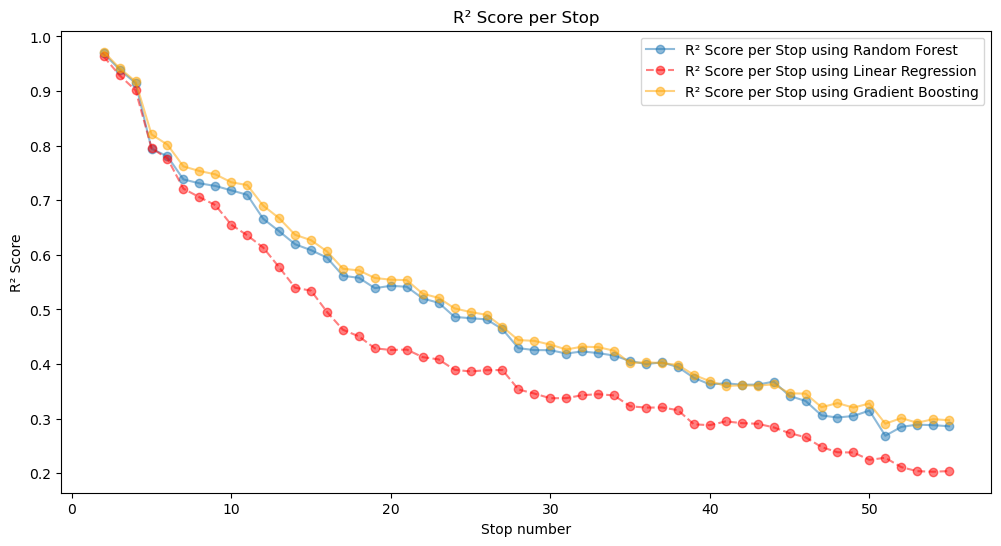

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Y_pred = multi_rf.predict(X_test)

r2_per_stop = []
for i in range(Y_test.shape[1]):
    r2 = r2_score(Y_test[:, i], Y_pred[:, i])
    r2_per_stop.append(r2)

plt.figure(figsize=(12, 6))
plt.plot(range(2, 56), r2_per_stop, marker='o',alpha=0.5, label='R² Score per Stop using Random Forest')
plt.plot(range(2, 56), r2_per_stop_l, marker='o', linestyle='--', alpha=0.5, color='red' , label='R² Score per Stop using Linear Regression')
plt.plot(range(2, 56), r2_per_stop_g, marker='o', linestyle='-', alpha=0.5, color='orange' , label='R² Score per Stop using Gradient Boosting')
plt.xlabel('Stop number')
plt.ylabel('R² Score')
plt.title('R² Score per Stop')
plt.legend()
plt.show()

Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.


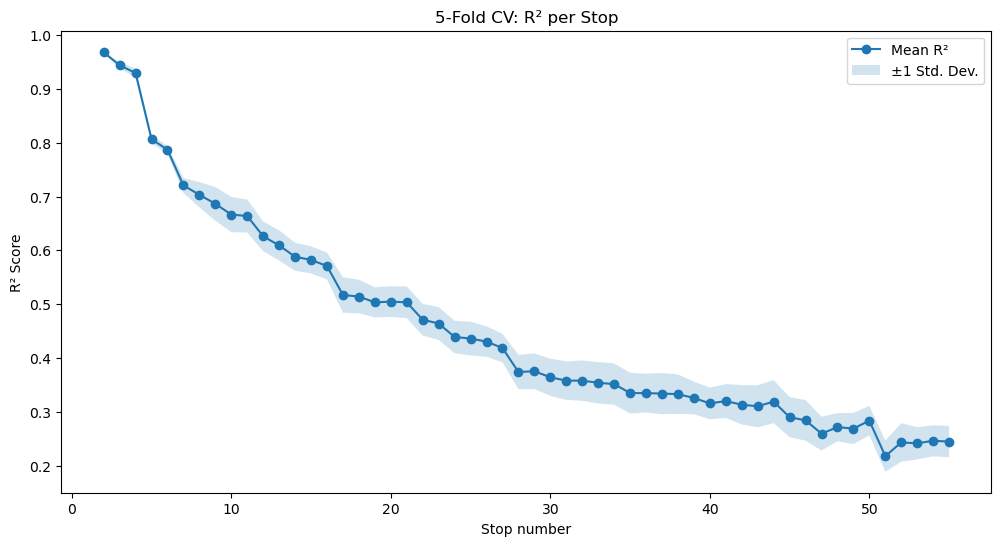

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

r2_folds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X[train_idx], X[test_idx]
    Y_tr, Y_te = Y[train_idx], Y[test_idx]

    base_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
    model = MultiOutputRegressor(base_rf, n_jobs=4)
    model.fit(X_tr, Y_tr)

    Y_pred = model.predict(X_te)

    r2_per_stop = [r2_score(Y_te[:, i], Y_pred[:, i]) 
                   for i in range(Y.shape[1])]
    r2_folds.append(r2_per_stop)
    print(f"Fold {fold} done.")

r2_folds = np.array(r2_folds)
mean_r2 = r2_folds.mean(axis=0)
std_r2 = r2_folds.std(axis=0)
stops = list(range(2, 56)) 
plt.figure(figsize=(12, 6))
plt.plot(stops, mean_r2, marker='o', label='Mean R²')
plt.fill_between(stops,mean_r2 - std_r2,mean_r2 + std_r2,alpha=0.2,label='±1 Std. Dev.')
plt.xlabel('Stop number')
plt.ylabel('R² Score')
plt.title(f'{n_splits}-Fold CV: R² per Stop')
plt.legend()
plt.show()

Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.


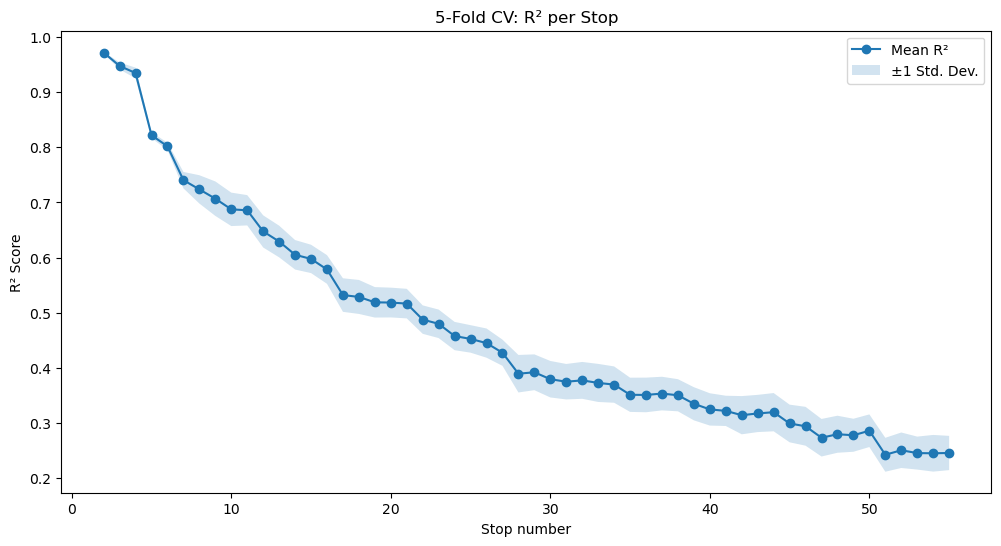

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

r2_folds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X[train_idx], X[test_idx]
    Y_tr, Y_te = Y[train_idx], Y[test_idx]

    base_rf = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model = MultiOutputRegressor(base_rf, n_jobs=4)
    model.fit(X_tr, Y_tr)

    Y_pred = model.predict(X_te)

    r2_per_stop = [r2_score(Y_te[:, i], Y_pred[:, i]) 
                   for i in range(Y.shape[1])]
    r2_folds.append(r2_per_stop)
    print(f"Fold {fold} done.")

r2_folds = np.array(r2_folds)
mean_r2 = r2_folds.mean(axis=0)
std_r2 = r2_folds.std(axis=0)
stops = list(range(2, 56)) 
plt.figure(figsize=(12, 6))
plt.plot(stops, mean_r2, marker='o', label='Mean R²')
plt.fill_between(stops,mean_r2 - std_r2,mean_r2 + std_r2,alpha=0.2,label='±1 Std. Dev.')
plt.xlabel('Stop number')
plt.ylabel('R² Score')
plt.title(f'{n_splits}-Fold CV: R² per Stop')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


features_columns = [
        'planned_time_arrival','planned_time_departure',
        'delay_arrival','delay_departure',
        'ptcar_latitude','ptcar_longitude',
        'holiday','weekend','day_after_rest',
        'temperature','dewpoint','relative_humidity',
        'precipitation','snowfall','wind_direction',
        'wind_speed','pressure',
        'departure_month','departure_day','departure_weekday','departure_year'
    ]
X, Y = create_dataset_multi(trajet_valid_df, features_columns)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

base_gb = GradientBoostingRegressor(random_state=42, n_estimators=1000)

multi_gb = MultiOutputRegressor(base_gb, n_jobs=4)
multi_gb.fit(X_train, Y_train)

y_pred = multi_gb.predict(X_test)

overall_r2 = r2_score(Y_test, y_pred)
overall_rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

print(f"Overall R² score: {overall_r2:.4f}")

Y_pred = multi_gb.predict(X_test)

r2_per_stop_g = []
for i in range(Y_test.shape[1]):
    r2 = r2_score(Y_test[:, i], Y_pred[:, i])
    r2_per_stop_g.append(r2)


Overall R² score: 0.4639


Overall R² score: 0.4745
Overall R² score: 0.5134
[0.9979013850010907, 0.9480118151428648, 0.9341656481063627, 0.9218870232004946, 0.8922490276450451, 0.871537458633305, 0.7826773076966017, 0.7412554822563007, 0.6991265849871648, 0.67935808208104, 0.6446630645543721, 0.5975570636338634, 0.5959833181287801, 0.5797084259513292, 0.5794355186925881, 0.578235424702674, 0.5537757429313285, 0.5480253633409687, 0.5290749046513689, 0.5271133390123366, 0.5158866058310877, 0.4987036069213988, 0.45735029594630927, 0.4581536683324897, 0.4352618609134683, 0.4277000992599419, 0.42853287735399537, 0.4263318200731959, 0.41928323150030444, 0.4011044409585802, 0.39916899928287475, 0.4013387329104787, 0.39579208685100165, 0.3876618229052078, 0.37429348610425794, 0.37173372978744224, 0.37164225022597164, 0.3715702312172632, 0.3724385807856264, 0.3499576158016817, 0.34767863593157644, 0.3272150613496011, 0.331079676694762, 0.33051457384942606, 0.3412214454664291, 0.30098335397112186, 0.3105189318546493, 0.3

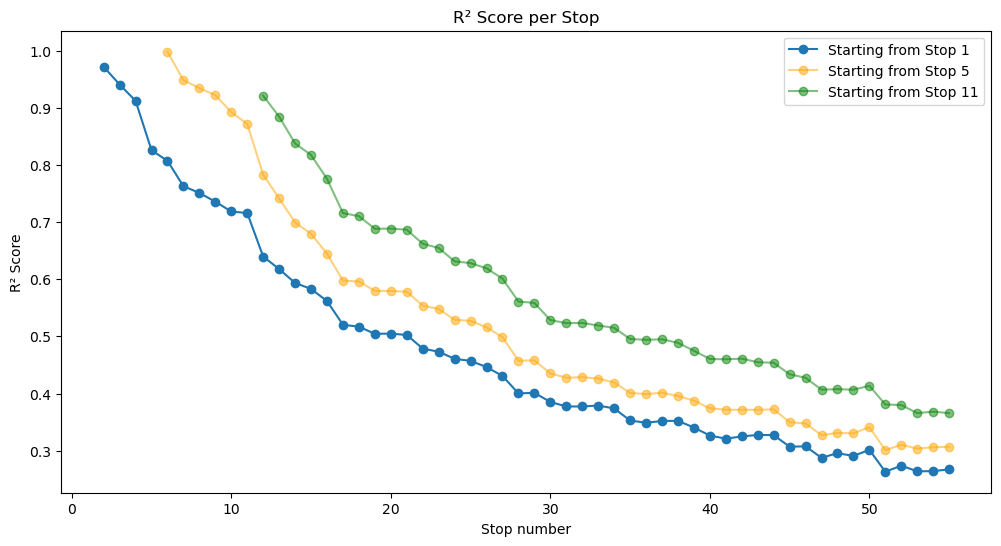

In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


features_columns = [
        'planned_time_arrival','planned_time_departure',
        'delay_arrival','delay_departure',
        'ptcar_latitude','ptcar_longitude',
        'holiday','weekend','day_after_rest',
        'temperature','dewpoint','relative_humidity',
        'precipitation','snowfall','wind_direction',
        'wind_speed','pressure',
        'departure_month','departure_day','departure_weekday','departure_year'
    ]
X, Y = create_dataset_multi(trajet_valid_df, features_columns)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

base_gb = GradientBoostingRegressor(random_state=42)

multi_gb = MultiOutputRegressor(base_gb, n_jobs=4)
multi_gb.fit(X_train, Y_train)

y_pred = multi_gb.predict(X_test)

overall_r2 = r2_score(Y_test, y_pred)
overall_rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

print(f"Overall R² score: {overall_r2:.4f}")

Y_pred = multi_gb.predict(X_test)

r2_per_stop_g = []
for i in range(Y_test.shape[1]):
    r2 = r2_score(Y_test[:, i], Y_pred[:, i])
    r2_per_stop_g.append(r2)


features_columns = [
        'planned_time_arrival', 'planned_time_departure',
        'delay_arrival', 'delay_departure',
        'ptcar_latitude', 'ptcar_longitude',
        'holiday', 'weekend', 'day_after_rest',
        'temperature', 'dewpoint', 'relative_humidity',
        'precipitation', 'snowfall', 'wind_direction',
        'wind_speed', 'pressure',
        'departure_month', 'departure_day', 'departure_weekday', 'departure_year'
    ]
X, Y = create_dataset_multi(trajet_valid_df,features_columns)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

base_gb = GradientBoostingRegressor(random_state=42)

multi_gb = MultiOutputRegressor(base_gb, n_jobs=4)
multi_gb.fit(X_train, Y_train)

y_pred = multi_gb.predict(X_test)

overall_r2 = r2_score(Y_test, y_pred)
overall_rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

print(f"Overall R² score: {overall_r2:.4f}")

Y_pred = multi_gb.predict(X_test)

r2_per_stop_g2 = []
for i in range(Y_test.shape[1]):
    r2 = r2_score(Y_test[:, i], Y_pred[:, i])
    r2_per_stop_g2.append(r2)

print(r2_per_stop_g2)



features_columns = [
        'planned_time_arrival', 'planned_time_departure',
        'delay_arrival', 'delay_departure',
        'ptcar_latitude', 'ptcar_longitude',
        'holiday', 'weekend', 'day_after_rest',
        'temperature', 'dewpoint', 'relative_humidity',
        'precipitation', 'snowfall', 'wind_direction',
        'wind_speed', 'pressure',
        'departure_month', 'departure_day', 'departure_weekday', 'departure_year'
    ]
X, Y = create_dataset_multi(trajet_valid_df, features_columns)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

base_gb = GradientBoostingRegressor(random_state=42)

multi_gb = MultiOutputRegressor(base_gb, n_jobs=4)
multi_gb.fit(X_train, Y_train)

y_pred = multi_gb.predict(X_test)

overall_r2 = r2_score(Y_test, y_pred)
overall_rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

print(f"Overall R² score: {overall_r2:.4f}")

Y_pred = multi_gb.predict(X_test)

r2_per_stop_g3 = []
for i in range(Y_test.shape[1]):
    r2 = r2_score(Y_test[:, i], Y_pred[:, i])
    r2_per_stop_g3.append(r2)

plt.figure(figsize=(12, 6))
plt.plot(range(2, 56), r2_per_stop_g, marker='o', label='Starting from Stop 1')
plt.plot(range(6, 56), r2_per_stop_g2, marker='o', linestyle='-', alpha=0.5, color='orange' , label='Starting from Stop 5')
plt.plot(range(12, 56), r2_per_stop_g3, marker='o',alpha = 0.5 , color = 'green', label='Starting from Stop 11')
plt.xlabel('Stop number')
plt.ylabel('R² Score')
plt.title('R² Score per Stop')
plt.legend()
plt.show()
